Largely adapted from these tutorials:

https://github.com/openai/gym

https://pylessons.com/CartPole-reinforcement-learning

https://aleksandarhaber.com/cart-pole-control-environment-in-openai-gym-gymnasium-introduction-to-openai-gym/

https://github.com/AleksandarHaber/Demonstration-of-Cart-Pole-OpenAI-Gym-Reinforcement-Learning-Environment-in-Python-/blob/main/cartPoleExplained.py

https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

https://github.com/Farama-Foundation/Gymnasium/blob/main/docs/tutorials/training_agents/reinforce_invpend_gym_v26.py

A2C:
https://github.com/Farama-Foundation/Gymnasium/blob/main/docs/tutorials/gymnasium_basics/vector_envs_tutorial.py

In [1]:
# import local package
# import sys
# sys.path.append('/Users/xxu35/Library/CloudStorage/GoogleDrive-xxu35@ncsu.edu/My Drive/_MachineLearning/GymNikki')
# print(sys.path)

['/Users/xxu35/Library/CloudStorage/GoogleDrive-xxu35@ncsu.edu/My Drive/_MachineLearning', '/Users/xxu35/opt/anaconda3/lib/python39.zip', '/Users/xxu35/opt/anaconda3/lib/python3.9', '/Users/xxu35/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/xxu35/opt/anaconda3/lib/python3.9/site-packages', '/Users/xxu35/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/xxu35/Library/CloudStorage/GoogleDrive-xxu35@ncsu.edu/My Drive/_MachineLearning/GymnasiumNikkiCopy']


In [2]:
from __future__ import annotations
from IPython import display

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

# import local package
import sys
sys.path.append('/Users/xxu35/Library/CloudStorage/GoogleDrive-xxu35@ncsu.edu/My Drive/_MachineLearning/GymNikki')
# print(sys.path)
import gymnasium as gym

/Users/xxu35/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [82]:
def RHS(x,t, Vm):
    position, angle, velocity, angular_velocity = x

    # self.fps = 50
    gravity = 9.81
    masscart = 0.57+0.37
    masspole = 0.230
    total_mass = masspole + masscart
    length = 0.3302  # actually half the pole's length
    # polemass_length = (self.masspole * self.length)
    force_mag = 10.0 # should be 8 for our case?
    tau = 0.02  # seconds between state updates

    # from Emi's thesis
    r_mp = 6.35e-3 # motor pinion radius
    Jm = 3.90e-7 # rotor moment of inertia
    Kg = 3.71 # planetary gearbox gear ratio
    Rm = 2.6 # motor armature resistance
    # both of these are in N.m.s/RAD, not degrees
    Beq = 5.4 #  equivalent viscous damping coecient as seen at the motor pinion
    Bp = 0.0024 # viscous damping doecient, as seen at the pendulum axis

    # dynamics for actuator
    Kt = 0.00767 # motor torque constant
    Km = 0.00767 # Back-ElectroMotive-Force (EMF) Constant V.s/RAD
        
    costheta = np.cos(angle)
    sintheta = np.sin(angle)

        
    d = 4 * masscart * r_mp**2 + masspole * r_mp**2 + 4 * Jm * Kg**2 + 3 * r_mp**2 * masspole * sintheta**2

    a33 = -4 * ( Rm * r_mp**2 * Beq + Kg**2 * Kt * Km
              ) / (
                Rm * d
              )
    
    a34 = - ( 3 * r_mp**2 * Bp * costheta + 4 * masspole * length**2 * r_mp**2 * sintheta * angular_velocity 
            ) / (
                length * d
            )

    a43 = -3 * ( Rm * r_mp**2 * Beq + Kg**2 * Kt * Km
            ) * costheta / (
                Rm * length * d 
            ) 
    
    a44 = -3 * (
                    ( total_mass * r_mp**2 + Jm * Kg**2) * Bp + 
                    ( masspole**2 * length**2 * r_mp**2 * costheta * sintheta * angular_velocity )
                ) / (
                    masspole * length**2 * d
                )
    
    
    # extra forces on velocity term (Emi's thesis eq 3.2 second plus term)
    aa3 = ( 3 * masspole * r_mp**2 * gravity * costheta * sintheta
            ) / (
            d
            )
    
    aa4 = ( 3 * (
                    total_mass * r_mp**2 + Jm * Kg**2
                ) * gravity * sintheta
            ) / (
            length * d
            )
    
    # controller
    b3 = (4 * r_mp * Kg * Kt) / (Rm * d)
    
    b4 = (3 * r_mp * Kg * Kt * costheta) / (length * Rm * d)
    
    dxdt = [ velocity + 0 * Vm, 
             angular_velocity + 0 * Vm, 
             a33 * velocity + a34 * angular_velocity + aa3 + b3 * Vm, 
             a43 * velocity + a44 * angular_velocity + aa4 + b4 * Vm
           ] # + ( 0, 0, b3*0, b4*0) # b3 and b4 should be multiplied by u = Vm (cart's motor) 
    
    return np.array(dxdt, dtype=np.float32)



In [83]:
x0 = [0.1, - 0.1, 0 , 0 ]

h_in = .02 #This is the step size.

t0 = 0; tf = 25; 

num_steps = int(np.ceil(tf/h_in)) #The np.ceil is defensive coding: what if h doesn't divide [0,5] evenly

t = np.linspace(t0,tf,num_steps+1)

h_in = tf/num_steps #This updates h to account for the possibility that it changed due to np.ceil.

Vm = 0 # RHS parameter - control u = Vm (voltage of motor on cart)

In [70]:
## this block uses SciPy odeint
from scipy.integrate import odeint

sol_odeint = odeint(RHS, x0, t, args=(Vm,))

In [72]:
## this block uses explicit Euler
def explicit_Euler(h):
    """
    num_steps = int(np.ceil(5./h)) #The np.ceil is defensive coding: what if h doesn't divide [0,5] evenly
    t = np.linspace(0,5,num_steps+1)
    h = 5./num_steps #This updates h to account for the possibility that it changed due to np.ceil.
    x = np.zeros(t.shape)
    x[0] = -.5 #Initial condition is -.5
    
    #I'm including three different implementations here, one with a for loop, one with a dense matrix
    #and one with a sparse matrix, for reference.
    """
    x = np.zeros((t.shape[0],4))
    x[0,:] = x0 
    
    #For loop implementation
    for i in range(num_steps):
        
        x[i+1,:] = x[i,:] + h*RHS(x[i,:], t[i], Vm)
        
    """
    #Dense matrix implementation
    
    A = np.eye(len(t)) + np.diag(-(1+h)*np.ones(len(t)-1),-1)
    b = h*np.sin(t)
    b[0] = -.5
    x = la.solve(A,b)
    
    #Sparse matrix implementation
    
    A = diags(np.ones(len(t)),0) + diags(-(1+h)*np.ones(len(t)-1),-1)
    b = h*np.sin(t)
    b[0] = -.5
    x = spsolve(A,b)

    """
    
    return (t,x) #Returns a tuple with both the time steps and the function values

(t,sol_Euler) = explicit_Euler(h_in)

In [146]:
def RHS_siEuler(v,y,t, Vm):
    
    position, angle = y
    velocity, angular_velocity = v
    # x = np.append(y,v)
    
    # self.fps = 50
    gravity = 9.81
    masscart = 0.57+0.37
    masspole = 0.230
    total_mass = masspole + masscart
    length = 0.3302  # actually half the pole's length
    # polemass_length = (self.masspole * self.length)
    force_mag = 10.0 # should be 8 for our case?
    tau = 0.02  # seconds between state updates

    # from Emi's thesis
    r_mp = 6.35e-3 # motor pinion radius
    Jm = 3.90e-7 # rotor moment of inertia
    Kg = 3.71 # planetary gearbox gear ratio
    Rm = 2.6 # motor armature resistance
    # both of these are in N.m.s/RAD, not degrees
    Beq = 5.4 #  equivalent viscous damping coecient as seen at the motor pinion
    Bp = 0.0024 # viscous damping doecient, as seen at the pendulum axis

    # dynamics for actuator
    Kt = 0.00767 # motor torque constant
    Km = 0.00767 # Back-ElectroMotive-Force (EMF) Constant V.s/RAD
        
    costheta = np.cos(angle)
    sintheta = np.sin(angle)

        
    d = 4 * masscart * r_mp**2 + masspole * r_mp**2 + 4 * Jm * Kg**2 + 3 * r_mp**2 * masspole * sintheta**2

    a33 = -4 * ( Rm * r_mp**2 * Beq + Kg**2 * Kt * Km
              ) / (
                Rm * d
              )
    
    a34 = - ( 3 * r_mp**2 * Bp * costheta + 4 * masspole * length**2 * r_mp**2 * sintheta * angular_velocity 
            ) / (
                length * d
            )

    a43 = -3 * ( Rm * r_mp**2 * Beq + Kg**2 * Kt * Km
            ) * costheta / (
                Rm * length * d 
            ) 
    
    a44 = -3 * (
                    ( total_mass * r_mp**2 + Jm * Kg**2) * Bp + 
                    ( masspole**2 * length**2 * r_mp**2 * costheta * sintheta * angular_velocity )
                ) / (
                    masspole * length**2 * d
                )
    
    
    # extra forces on velocity term (Emi's thesis eq 3.2 second plus term)
    aa3 = ( 3 * masspole * r_mp**2 * gravity * costheta * sintheta
            ) / (
            d
            )
    
    aa4 = ( 3 * (
                    total_mass * r_mp**2 + Jm * Kg**2
                ) * gravity * sintheta
            ) / (
            length * d
            )
    
    # controller
    b3 = (4 * r_mp * Kg * Kt) / (Rm * d)
    
    b4 = (3 * r_mp * Kg * Kt * costheta) / (length * Rm * d)
    
    '''dxdt = [ velocity + 0 * Vm, 
             angular_velocity + 0 * Vm, 
             a33 * velocity + a34 * angular_velocity + aa3 + b3 * Vm, 
             a43 * velocity + a44 * angular_velocity + aa4 + b4 * Vm
           ] # + ( 0, 0, b3*0, b4*0) # b3 and b4 should be multiplied by u = Vm (cart's motor) 
    '''
    dydt = v
    # dvdt = RHS(x,t,Vm)
    dvdt = [ a33 * velocity + a34 * angular_velocity + aa3 + b3 * Vm, 
             a43 * velocity + a44 * angular_velocity + aa4 + b4 * Vm
           ]
    dvdt = np.array(dvdt, dtype = np.float32)
    # return np.append(dydt, dvdt[2:4:1])
    return dydt, dvdt



In [148]:
## this block uses semi-implicit Euler
def semi_implicit_Euler(h):
    y = np.zeros((t.shape[0],2))
    v = np.zeros((t.shape[0],2))
    y[0,:] = x0[0:2:1]
    v[0,:] = x0[2:4:1]
    
    #For loop implementation
    for i in range(num_steps):
        yy, vv = RHS_siEuler(y = y[i,:], v = v[i,:], t=t[i], Vm = Vm)
        v[i+1,:] = v[i,:] + h*vv
        yy, vv = RHS_siEuler(y = y[i,:], v = v[i+1,:], t=t[i], Vm = Vm)
        y[i+1,:] = y[i,:] + h*yy

    return (t,y) # only look at position and angle position
(t,sol_SemiImplicitEuler) = semi_implicit_Euler(h_in)

In [152]:
## debugging block
"""
yy,vv = RHS_siEuler(y = x0[0:2:1], v = x0[2:4:1], t= 0.1, Vm = Vm)
zz = np.append(yy,vv)
type(vv)
"""

import pygame

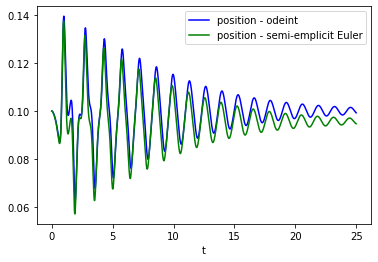

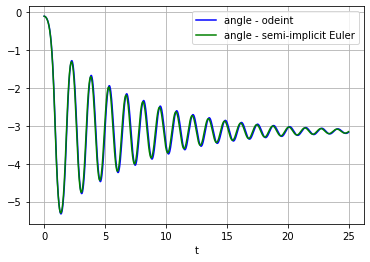

In [151]:


plt.plot(t, sol_odeint[:, 0], 'b', label='position - odeint')
plt.plot(t, sol_SemiImplicitEuler[:, 0], 'g', label='position - semi-emplicit Euler')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

plt.plot(t, sol_odeint[:, 1], 'b', label='angle - odeint')
plt.plot(t, sol_SemiImplicitEuler[:, 1], 'g', label='angle - semi-implicit Euler')
plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()

In [3]:
env = gym.make("CartPole-v1") #, render_mode="rgb_array")
plt.rcParams["figure.figsize"]=(10,5)
env.action_space.n

2

In [4]:
def Random_games():
    # Each of this episode is its own game.
    for episode in range(10):
        observation, info = env.reset(seed=42)
        # this is each frame, up to 500...but we wont make it that far with random.
        
        for t in range(50):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            
            # plt.imshow(env.render())
            # display.display(plt.gcf())    
            # display.clear_output(wait=True)
            # env.render()
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()

            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            observation, reward, terminated, truncated, info = env.step(action)
            
            if terminated or truncated:
                observation, info = env.reset()
            
            # lets print everything in one line:
            print(t, observation, reward, terminated, info, action)
            # if done:
            #     break
        env.close()



In [5]:
from tensorflow import keras
from keras import layers, models, optimizers, losses, metrics

keras.backend.clear_session() # clear previous ones

# Neural Network model for Deep Q Learning
def OurModel(obs_space_dims: int, action_space_dims: int):
    
    layer1 = 30  # Nothing special with 30, feel free to change
    layer2 = 30  
        
    model = models.Sequential(
        [
            # keras.Input(shape=input_shape), 
            layers.Dense(obs_space_dims, activation='tanh'), 
            layers.Dense(layer1, activation='tanh'), 
            layers.Dense(layer2, activation='tanh'), 
            layers.Dense(action_space_dims, activation='tanh'), 
        ]
    ); 
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss=losses.MeanSquaredError(),
                  metrics=metrics.Accuracy()); 
    model.summary()
    return model
    
    # X_input = Input(input_shape)

2023-11-15 16:19:39.961551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/xxu35/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [88]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
# from torch.distributions.normal import Normal

# import gymnasium as gym

# import local package
import sys
sys.path.append('/Users/xxu35/Library/CloudStorage/GoogleDrive-xxu35@ncsu.edu/My Drive/_MachineLearning/GymNikki')
# print(sys.path)
import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)


In [206]:

# %%
# Policy Network
# ~~~~~~~~~~~~~~
#
# .. image:: /_static/img/tutorials/reinforce_invpend_gym_v26_fig2.png
#
# We start by building a policy that the agent will learn using REINFORCE.
# A policy is a mapping from the current environment observation to a probability distribution of the actions to be taken.
# The policy used in the tutorial is parameterized by a neural network. It consists of 2 linear layers that are shared between both the predicted mean and standard deviation.
# Further, the single individual linear layers are used to estimate the mean and the standard deviation. ``nn.Tanh`` is used as a non-linearity between the hidden layers.
# The following function estimates a mean and standard deviation of a normal distribution from which an action is sampled. Hence it is expected for the policy to learn
# appropriate weights to output means and standard deviation based on the current observation.

class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 10  # Nothing special with 16, feel free to change
        hidden_space2 = 10  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        beta = 1
        action_stddevs = (1/beta) * torch.log(
            1 + torch.exp(beta * self.policy_stddev_net(shared_features))
        )
        
        return action_means, action_stddevs


In [207]:
"""
distrib = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
action = distrib.sample()

ln_prob = distrib.log_prob(action)
torch.exp(ln_prob)
"""

'\ndistrib = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))\naction = distrib.sample()\n\nln_prob = distrib.log_prob(action)\ntorch.exp(ln_prob)\n'

In [210]:

# %%
# Building an agent
# ~~~~~~~~~~~~~~~~~
#
# .. image:: /_static/img/tutorials/reinforce_invpend_gym_v26_fig3.jpeg
#
# Now that we are done building the policy, let us develop **REINFORCE** which gives life to the policy network.
# The algorithm of REINFORCE could be found above. As mentioned before, REINFORCE aims to maximize the Monte-Carlo returns.
#
# Fun Fact: REINFORCE is an acronym for " 'RE'ward 'I'ncrement 'N'on-negative 'F'actor times 'O'ffset 'R'einforcement times 'C'haracteristic 'E'ligibility
#
# Note: The choice of hyperparameters is to train a decently performing agent. No extensive hyperparameter
# tuning was done.
#

class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 5e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-9  # small number for mathematical stability

        # self.probs = []  # Stores probability values of the sampled action
        self.ln_probs = []  # Stores log probability values of the sampled action ln ( pi_theta(a_t|s_t) )
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.NAdam(self.net.parameters(), lr=self.learning_rate, 
                                         momentum_decay=5e-3, betas=(0.95,0.99))
        # self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        # mean and standard deviation and sample an action
        
        # distrib = torch.distributions.normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        # distrib = torch.distributions.normal(action_means[0], action_stddevs[0])
        # action = distrib.sample()
        # action = distrib.rsample()
        # ln_prob = distrib.log_prob(action)
        
        distrib = torch.distributions.normal.Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        ln_prob = distrib.log_prob(action)

        action = action.numpy()

        self.ln_probs.append(ln_prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.ln_probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.ln_probs = []
        self.rewards = []

In [211]:

# %%
# Now lets train the policy using REINFORCE to master the task of Inverted Pendulum.
#
# Following is the overview of the training procedure
#
#    for seed in random seeds
#        reinitialize agent
#
#        for episode in range of max number of episodes
#            until episode is done
#                sample action based on current observation
#
#                take action and receive reward and next observation
#
#                store action take, its probability, and the observed reward
#            update the policy
#
# Note: Deep RL is fairly brittle concerning random seed in a lot of common use cases (https://spinningup.openai.com/en/latest/spinningup/spinningup.html).
# Hence it is important to test out various seeds, which we will be doing.


# Create and wrap the environment
env = gym.make("InvertedPendulum-v5") #, render_mode="human") #NX change v1 to v2
# env = gym.make("CartPole-v2") #, render_mode="human") #NX change v1 to v2
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []

for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    # random.seed(seed)
    # np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

Episode: 0 Average Reward: 4
Episode: 1000 Average Reward: 69
Episode: 2000 Average Reward: 217
Episode: 3000 Average Reward: 931
Episode: 4000 Average Reward: 878
Episode: 0 Average Reward: 963
Episode: 1000 Average Reward: 97
Episode: 2000 Average Reward: 719
Episode: 3000 Average Reward: 926
Episode: 4000 Average Reward: 990
Episode: 0 Average Reward: 980
Episode: 1000 Average Reward: 134
Episode: 2000 Average Reward: 940
Episode: 3000 Average Reward: 862
Episode: 4000 Average Reward: 1000
Episode: 0 Average Reward: 980
Episode: 1000 Average Reward: 32
Episode: 2000 Average Reward: 159
Episode: 3000 Average Reward: 802
Episode: 4000 Average Reward: 875
Episode: 0 Average Reward: 905
Episode: 1000 Average Reward: 26
Episode: 2000 Average Reward: 67
Episode: 3000 Average Reward: 291
Episode: 4000 Average Reward: 987


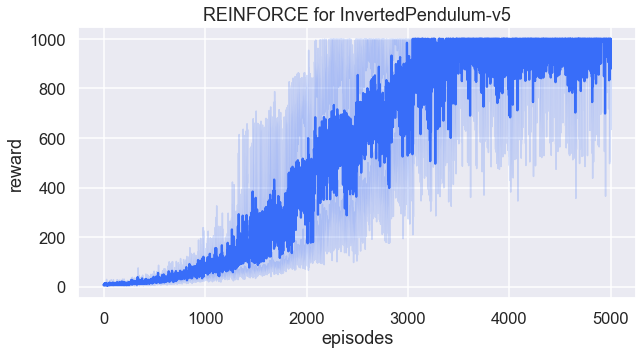

In [212]:

# %%
# Plot learning curve
# ~~~~~~~~~~~~~~~~~~~
#
rewards_to_plot = [[reward for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v5"
)
plt.show()